## Recycling Robot 

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

In [137]:
#base_seed
random_seed = 142
np.random.seed(random_seed)


#### Environment

In [138]:
#states and actions
states = ['high', 'low']
actions = { 'high': ['search', 'wait'],
            'low': ['search', 'wait', 'recharge']}

In [139]:
#environment
def environment_steps(state, action, alpha_param, beta_param, r_search, r_wait):
    if state == 'high':
        if action == 'search':
            if np.random.rand() < alpha_param:
                next_state = 'high'
            else:
                next_state = 'low'
            reward = r_search
        elif action == 'wait':
            next_state = 'high'
            reward = r_wait
    elif state == 'low':
        if action == 'search':
            if np.random.rand() < beta_param:
                next_state = 'low'
                reward = r_search
            else:
                next_state = 'high'
                reward = -3
        elif action == 'wait':
            next_state = 'low'
            reward = r_wait
        elif action == 'recharge':
            next_state = 'high'
            reward = 0
    return next_state, reward

#### Training parameters

In [140]:
alpha_lr = 0.1  #learning rate for TD
gamma = 0.9     #discount factor
epochs = 100    # number of epochs
steps_per_epoch = 1000  #steps per epoch
epsilon = 0.1   #e-greedy for explore random actions

rewards_per_epoch = []

#### TD(0) Algorithm

In [141]:
def td_learning(alpha_lr, gamma, epochs, steps_per_epoch, epsilon, alpha_param, beta_param, r_search, r_wait):
    V = {state: 0.0 for state in states}      #Initializating value function V(s)
    #Policy pi(s) (Initial policy random)
    policy = {'high': {'search': 1/2, 'wait': 1/2},
              'low': {'search': 1/3, 'wait': 1/3, 'recharge': 1/3}}
    
    rewards_list = []

    for epoch in range(epochs):
        state = np.random.choice(states)
        total_reward = 0

        for step in range(steps_per_epoch):
            if np.random.rand() < epsilon:  
                action = np.random.choice(actions[state]) #exploration
            else:
                action_probs = policy[state]
                action = np.random.choice(list(action_probs.keys()), p=list(action_probs.values())) #explotation
            
            next_state, reward = environment_steps(state, action, alpha_param, beta_param, r_search, r_wait)
            total_reward += reward
            
            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] += alpha_lr * td_error   #updating TD(0)
            
            update_policy(policy, V, state, epsilon, alpha_param, beta_param, r_search, r_wait)  #updating policy based in V(s)
            
            state = next_state  #move to next state
                
        rewards_list.append(total_reward)  # store total_reward
    
    return V, policy, rewards_list

#### update policy values

In [142]:
#update policy values
def update_policy(policy, V, state, epsilon, alpha_param, beta_param, r_search, r_wait):
    #cases
    if state == 'high':
        # 'search' and 'wait' results in different states
        valid_actions = ['search', 'wait']
        value_search = r_search + gamma * (alpha_param * V['high'] + (1-alpha_param) * V['low'])
        value_wait = r_wait + gamma * V['high']
        
        #best action
        values = [value_search, value_wait]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)
            
    else:  # state == 'low'
        # 'low': actions result in different states
        valid_actions = ['search', 'wait', 'recharge']
        value_search = beta_param * (r_search + gamma * V['low']) + (1 - beta_param) * (-3 + gamma * V['high'])
        value_wait = r_wait + gamma * V['low']
        value_recharge = 0 + gamma * V['high']
        
        #best action
        values = [value_search, value_wait, value_recharge]
        best_action = valid_actions[np.argmax(values)]

        # Update policy with e-greedy
        for action in valid_actions:
            if action == best_action:
                policy[state][action] = 1 - epsilon + epsilon / len(valid_actions)
            else:
                policy[state][action] = epsilon / len(valid_actions)

#### Finding best parameters

In [143]:
def find_best_parameter_combinations():
    #test differents values
    alpha_values = np.arange(0.3, 1, 0.3)  #alpha: 0.1:0.9
    beta_values = np.arange(0.3, 1, 0.3)   #beta: 0.1:0.9
    r_search_values = np.arange(1, 6, 2)  # r_search: 1:5
    r_wait_values = np.arange(0, 4, 2)    # r_wait: 0:4
    
    best_mean_reward = -float('inf')
    best_alpha = None
    best_beta = None
    best_r_search = None
    best_r_wait = None
    results = []
    
    # Combinations (r_search > r_wait)
    valid_combinations = []
    for r_s, r_w in product(r_search_values, r_wait_values):
        if r_s > r_w:
            valid_combinations.append((r_s, r_w))
    
    for alpha_val, beta_val, (r_s_val, r_w_val) in product(alpha_values, beta_values, valid_combinations):
        print(f"Testing alpha={alpha_val:.1f}, beta={beta_val:.1f}, r_search={r_s_val}, r_wait={r_w_val}")
        
        # Global values of r_search and r_wait
        #global r_search, r_wait
        #r_search = r_s_val
        #r_wait = r_w_val
        
        # TD Algorithm
        V, policy, rewards_hist = td_learning(
            alpha_lr=alpha_lr, 
            gamma=gamma, 
            epochs=epochs, 
            steps_per_epoch=steps_per_epoch, 
            epsilon=epsilon,
            alpha_param=alpha_val,
            beta_param=beta_val,
            r_search=r_s_val,
            r_wait = r_w_val
            
        )
        
        mean_reward = np.mean(rewards_hist)
        results.append((alpha_val, beta_val, r_s_val, r_w_val, mean_reward))
        
        print(f" Average Reward: {mean_reward:.2f}")
        
        # Updating with best combination
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            best_alpha = alpha_val
            best_beta = beta_val
            best_r_search = r_s_val
            best_r_wait = r_w_val
    
    return best_alpha, best_beta, best_r_search, best_r_wait, best_mean_reward, results

In [144]:
print("Testing different combinations of alpha, beta, r_search and r_wait")
best_alpha, best_beta, best_r_search, best_r_wait, best_mean_reward, results = find_best_parameter_combinations()

print(f"\nBest combination: alpha={best_alpha:.1f}, beta={best_beta:.1f}, r_search={best_r_search}, r_wait={best_r_wait}")
print(f"Best average reward: {best_mean_reward:.2f}")

# Run with the best parameters to obtain the Optimal Policy
print(f"\nRunning with best parameters (alpha={best_alpha:.1f}, beta={best_beta:.1f}, r_search={best_r_search}, r_wait={best_r_wait})")

# Set best global values
#global r_search, r_wait
#r_search = best_r_search
#r_wait = best_r_wait

V, policy, rewards_hist = td_learning(alpha_lr=alpha_lr, 
                                        gamma=gamma, 
                                        epochs=epochs, 
                                        steps_per_epoch=steps_per_epoch, 
                                        epsilon=epsilon,
                                        alpha_param=best_alpha,
                                        beta_param=best_beta,
                                        r_search = best_r_search,
                                        r_wait = best_r_wait)

# Results
print(f"\nLearned V(s): {V}")
print(f"\nOptimal policy:")
for state in states:
    print(f"  {state}: {policy[state]}")

print(f"\nAverage reward: {np.mean(rewards_hist):.2f}")

Testing different combinations of alpha, beta, r_search and r_wait
Testing alpha=0.3, beta=0.3, r_search=1, r_wait=0
 Average Reward: 489.06
Testing alpha=0.3, beta=0.3, r_search=3, r_wait=0
 Average Reward: 1579.86
Testing alpha=0.3, beta=0.3, r_search=3, r_wait=2
 Average Reward: 1918.21
Testing alpha=0.3, beta=0.3, r_search=5, r_wait=0
 Average Reward: 2651.02
Testing alpha=0.3, beta=0.3, r_search=5, r_wait=2
 Average Reward: 2825.34
Testing alpha=0.3, beta=0.6, r_search=1, r_wait=0
 Average Reward: 515.22
Testing alpha=0.3, beta=0.6, r_search=3, r_wait=0
 Average Reward: 1608.75
Testing alpha=0.3, beta=0.6, r_search=3, r_wait=2
 Average Reward: 1942.40
Testing alpha=0.3, beta=0.6, r_search=5, r_wait=0
 Average Reward: 2734.84
Testing alpha=0.3, beta=0.6, r_search=5, r_wait=2
 Average Reward: 2879.86
Testing alpha=0.3, beta=0.9, r_search=1, r_wait=0
 Average Reward: 591.47
Testing alpha=0.3, beta=0.9, r_search=3, r_wait=0
 Average Reward: 2216.52
Testing alpha=0.3, beta=0.9, r_searc

Time: 41m 34s

Best combination: alpha=0.9, beta=0.9, r_search=5, r_wait=4
Best average reward: 4527.14

Running with best parameters (alpha=0.9, beta=0.9, r_search=5, r_wait=4)

In [145]:
print(f"\nRunning with best parameters (alpha={best_alpha:.1f}, beta={best_beta:.1f}, r_search={best_r_search}, r_wait={best_r_wait})")


Running with best parameters (alpha=0.9, beta=0.9, r_search=5, r_wait=2)


In [146]:
def save_results(rewards_history):
    # Save rewards in *txt
    with open('rewards_best_result.txt', 'w') as f:
        for reward in rewards_history:
            f.write(f"{reward}\n")

In [147]:
#visualization with best results
def plot_results(rewards_history, policy):
    
    plt.figure(figsize=(12, 5))    
    plt.subplot(1, 2, 1) #Figure 1
    plt.plot(rewards_history, alpha=0.7)
    plt.title('Total reward per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulate reward')
    plt.grid(linestyle='--', color='gray', alpha=0.5)

    plt.subplot(1, 2, 2) #Figure 2   
    policy_matrix = np.zeros((2, 3))
    policy_matrix[0, 0] = policy['high']['search']
    policy_matrix[0, 1] = policy['high']['wait']
    policy_matrix[0, 2] = 0                         
    policy_matrix[1, 0] = policy['low']['search'] 
    policy_matrix[1, 1] = policy['low']['wait'] 
    policy_matrix[1, 2] = policy['low']['recharge']     
    sns.heatmap(policy_matrix, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=['Search', 'Wait', 'Recharge'],
                    yticklabels=['High', 'Low'])
    plt.title('Optimal Policy (with action probabilities)')
    plt.ylabel('State')
    plt.xlabel('Action')    
    plt.tight_layout()
    #plt.savefig('policy_heatmap.png')
    plt.show()

In [148]:
V, policy, rewards_hist = td_learning(alpha_lr=alpha_lr, 
                                        gamma=gamma, 
                                        epochs=epochs, 
                                        steps_per_epoch=steps_per_epoch, 
                                        epsilon=epsilon,
                                        alpha_param=best_alpha,
                                        beta_param=best_beta,
                                        r_search=best_r_search,
                                        r_wait=best_r_wait                                        )


V(s) learned: {'high': np.float64(44.30560262258149), 'low': np.float64(40.78559574399043)}

Optimal Policy:
  high: {'search': 0.9500000000000001, 'wait': 0.05}
  low: {'search': 0.9333333333333333, 'wait': 0.03333333333333333, 'recharge': 0.03333333333333333}

Average(Reward): 4367.11
plot


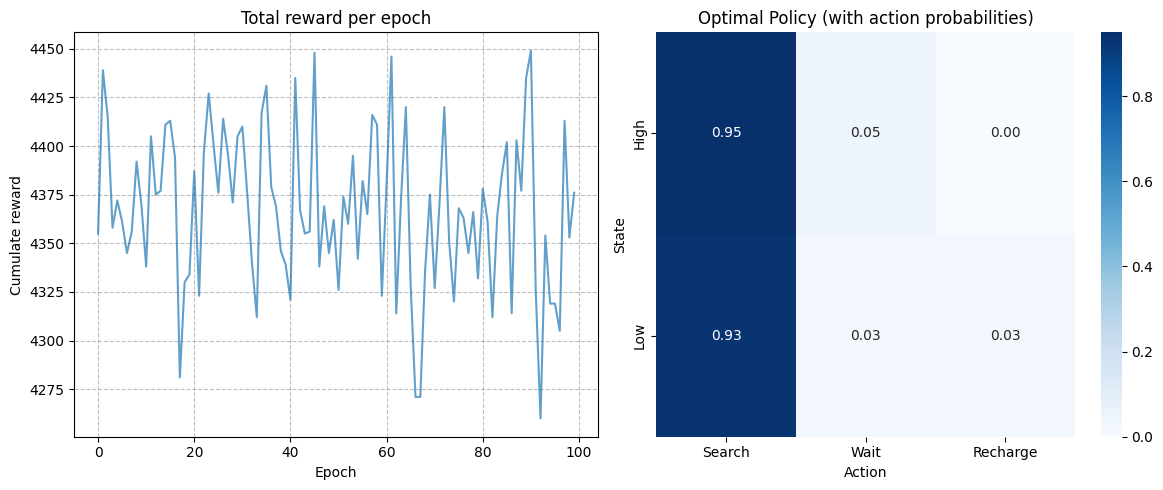

In [149]:
# Results
print(f"\nV(s) learned: {V}")
print(f"\nOptimal Policy:")
for state in states:
    print(f"  {state}: {policy[state]}")

print(f"\nAverage(Reward): {np.mean(rewards_hist):.2f}")   

# Visualization
print("plot")
plot_results(rewards_hist, policy)


In [150]:
save_results(rewards_hist)